**Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from tqdm import tqdm
from mpmath import mp, invertlaplace, mpc, mpf
from scipy import special

%matplotlib inline

**Parameters**

In [ ]:
gamma_1D = 1.0   # Decay rate
D = 0.5          # Detuning d = (omega_0 - epsilon)
Omega = 2        # Modulation frequency
Omega_R = 0.05   # Rabi frequency
omega_0 = 5 * gamma_1D
A = 0.025     # Modulation amplitude
k = 0.05

psi_ground = np.array([0, 1], dtype=complex)  # Initial ground state, outer product

t_final = 15
times = np.linspace(0, t_final / gamma_1D, 1000)
delay_times = np.linspace(0, t_final / gamma_1D, 1000)

omega_range = np.linspace(-50, 50, 2000)

**Resonance Fluorescence paper**

In [ ]:
def A_modulation(t):
    return A * np.cos(omega_0 * t)

def calculate_P(s, omega_R, gamma_1D, D):
    term1 = (s + 2 * gamma_1D)
    term2_inner = (s + gamma_1D)**2 + D**2
    term3 = omega_R**2 * (s + gamma_1D)

    P_s = (term1 * term2_inner) + term3
    return P_s


def calculate_B1(s, omega_R, gamma_1D, D):
    term_1 = -1j * (omega_R / 2)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D - 1j * D
    P_s = calculate_P(s, omega_R, gamma_1D, D)

    result = term_1 * term_2 * term_3 / (s * P_s)
    return result


def calculate_B2(s, omega_R, gamma_1D, D):
    term_1 = 1j * (omega_R / 2)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D + 1j * D
    P_s = calculate_P(s, omega_R, gamma_1D, D)

    result = term_1 * term_2 * term_3 / (s * P_s)
    return result


def calculate_B3(s, omega_R, gamma_1D, D):
    term_1 = -(s + gamma_1D * 2)
    term_2 = (s + gamma_1D)**2 + D**2
    P_s = calculate_P(s, omega_R, gamma_1D, D)

    result = term_1 * term_2 / (s * P_s)
    return result


def calculate_correlation_function(s, omega_R, gamma_1D, D):
    tau = 1 / gamma_1D
    D_normalized = D
    R_normalized = omega_R

    # Prefactor from paper
    prefactor = (0.25 * R_normalized**2) / (1 + D_normalized**2 + 0.5 * R_normalized**2)

    # P(s)
    P_s = calculate_P(s, omega_R, gamma_1D, D)

    # Numerator: P(s) - (ωR²/2)(s + γ)
    numerator = P_s - 0.5 * omega_R**2 * (s + 2 * gamma_1D)

    # Full expression
    result = prefactor * numerator / (s * P_s)

    return result



# Inverse Laplace transform using numerical integration
def inverse_laplace_transform(B_func, times, omega_R, gamma_1D, D, N=4000, c=0.1, omega_max=200):
    """
    Compute inverse Laplace transform numerically using the inverse Fourier transform.
    f(t) = (1/2π) ∫ F(iω) e^(iωt) dω
    """
    omega = np.linspace(-omega_max, omega_max, N)
    dw = omega[1] - omega[0]

    # Evaluate F(s) along the Bromwich contour s = c + iω
    s_values = c + 1j * omega
    F_values = np.array([B_func(s, omega_R, gamma_1D, D) for s in s_values])

    results = np.zeros(len(times), dtype=complex)

    for i, t in enumerate(times):
        if t <= 0:
            results[i] = 0
            continue

        # f(t) = (e^(ct)/2π) ∫ F(c + iω) e^(iωt) dω
        integrand = F_values * np.exp(1j * omega * t)
        integral = np.trapezoid(integrand, dx=dw)
        results[i] = np.exp(c * t) * integral / (2 * np.pi)

    return results

def compute_B1(times, omega_R, gamma_1D, D, k):
    # Get e^(ikt)⟨σ₋(t)⟩
    result_with_phase = inverse_laplace_transform(calculate_B1, times, omega_R, gamma_1D, D)

    # Remove phase to get ⟨σ₋(t)⟩
    result = result_with_phase #* np.exp(-1j * k * times)

    return result

def compute_B2(times, omega_R, gamma_1D, D, k):
    result_with_phase = inverse_laplace_transform(calculate_B2, times, omega_R, gamma_1D, D)

    # Remove phase to get ⟨σ₊(t)⟩
    result = result_with_phase #* np.exp(1j * k * times)

    return result


def compute_B3(times, omega_R, gamma_1D, D):
    return inverse_laplace_transform(calculate_B3, times, omega_R, gamma_1D, D)


def compute_correlation(times, omega_R, gamma_1D, D, k):
    result_with_phase = inverse_laplace_transform(calculate_correlation_function, times, omega_R, gamma_1D, D)
    result = result_with_phase #* np.exp(-1j * k * times)

    return result

In [ ]:
# @title
def optical_bloch_ode(t, c, k, gamma_1D, D, Omega_R, b_n, t_reference=0):
    # Let 1/Tau = Gamma_1D, Tau = 1/Gamma_1D, k = 0, phi = 0

    t_prime = t_reference + t
    D_t = D + A * np.sin(omega_0 * t_prime)

    # Phase factors
    phase_pos = np.exp(1j * k * t_prime)   # e^(ikt')
    phase_neg = np.exp(-1j * k * t_prime)  # e^(-ikt')

    B = np.array([
        [-(gamma_1D + 1j * D),      0,                         0.5j * Omega_R],
        [0,                         -(gamma_1D - 1j * D),      -0.5j * Omega_R],
        [1j * Omega_R,  -1j * Omega_R, -2 * gamma_1D]
    ], dtype=complex)

    return B @ c + b_n


def solve_c1(c1_initial, times, k, gamma_1D, D, Omega_R):
    # b_1 = -2/τ
    b1 = np.array([0, 0, -2 * gamma_1D], dtype=complex)

    def ode_func(t, c):
        return optical_bloch_ode(t, c, k, gamma_1D, D, Omega_R, b1, t_reference=0)

    solution = solve_ivp(
        ode_func,
        t_span=(times[0], times[-1]),
        y0=c1_initial,
        t_eval=times,
        method='DOP853',
        rtol=1e-10,
        atol=1e-12
    )

    return solution


def solve_c2(c2_initial, delay_times, k, gamma_1D, D, Omega_R, sigma_plus_at_t, t_reference=0):
    # b_2 = -2/τ · ⟨σ₊(t)⟩ in third position
    b2 = np.array([0, 0, -2 * gamma_1D * sigma_plus_at_t], dtype=complex)

    # ODE wrapper
    def ode_func(delta_t, c):
        return optical_bloch_ode(delta_t, c, k, gamma_1D, D, Omega_R, b2, t_reference=t_reference)

    solution = solve_ivp(
        ode_func,
        t_span=(delay_times[0], delay_times[-1]),
        y0=c2_initial,
        t_eval=delay_times,
        method='DOP853',
        rtol=1e-10,
        atol=1e-12
    )

    return solution


def get_initial_c1_from_state(psi):
    # Density matrix
    rho = np.outer(psi, psi.conj())

    # Pauli operators
    sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
    sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    c1 = np.array([
        np.trace(rho @ sigma_minus),
        np.trace(rho @ sigma_plus),
        np.trace(rho @ sigma_z)
    ], dtype=complex)

    return c1


def get_initial_c2_from_c1_steady_state(c1_steady_state):
    sigma_plus_ss = c1_steady_state[1]
    sigma_z_ss = c1_steady_state[2].real

    c2_initial = np.array([
        (sigma_z_ss + 1) / 2,   # ⟨σ₊σ₋⟩ = (σz + 1)/2
        0,                      # ⟨σ₊(t)σ₊(t)⟩ = 0
        -sigma_plus_ss          # ⟨σ₊(t)σ_z(t)⟩ ≈ -⟨σ₊(t)⟩
    ], dtype=complex)

    return c2_initial

**Matplotlib**

In [ ]:
# @title
#############################################
########## Main Plots   #####################
#############################################


def plot_c1_solution(solution, times):
    """Plot c₁ solution components."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # ⟨σ₋(t)⟩
    axes[0].plot(times, solution.y[0].real, 'b-', linewidth=2, label='Re⟨σ₋⟩')
    axes[0].plot(times, solution.y[0].imag, 'r--', linewidth=2, label='Im⟨σ₋⟩')
    axes[0].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[0].set_ylabel('⟨σ₋(t)⟩', fontsize=12)
    axes[0].set_title('Single-Time: ⟨σ₋(t)⟩', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ⟨σ₊(t)⟩
    axes[1].plot(times, solution.y[1].real, 'b-', linewidth=2, label='Re⟨σ₊⟩')
    axes[1].plot(times, solution.y[1].imag, 'r--', linewidth=2, label='Im⟨σ₊⟩')
    axes[1].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[1].set_ylabel('⟨σ₊(t)⟩', fontsize=12)
    axes[1].set_title('Single-Time: ⟨σ₊(t)⟩', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # ⟨σ_z(t)⟩
    axes[2].plot(times, solution.y[2].real, 'g-', linewidth=2)
    axes[2].axhline(y=-1, color='k', linestyle=':', alpha=0.5, label='Ground')
    axes[2].axhline(y=1, color='k', linestyle=':', alpha=0.5, label='Excited')
    axes[2].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[2].set_ylabel('⟨σ_z(t)⟩', fontsize=12)
    axes[2].set_title('Single-Time: ⟨σ_z(t)⟩', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_c2_solution(solution, times):
    """Plot c₂ solution components."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # ⟨σ₊(t)σ₋(t')⟩
    axes[0].plot(times, solution.y[0].real, 'b-', linewidth=2, label='Real')
    axes[0].plot(times, solution.y[0].imag, 'r--', linewidth=2, label='Imaginary')
    axes[0].set_xlabel('Time Delay t\' (1/γ₁D)', fontsize=12)
    axes[0].set_ylabel('⟨σ₊(t)σ₋(t\')⟩', fontsize=12)
    axes[0].set_title('Two-Time: ⟨σ₊(t)σ₋(t\')⟩', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ⟨σ₊(t)σ₊(t')⟩
    axes[1].plot(times, solution.y[1].real, 'b-', linewidth=2, label='Real')
    axes[1].plot(times, solution.y[1].imag, 'r--', linewidth=2, label='Imaginary')
    axes[1].set_xlabel('Time Delay t\' (1/γ₁D)', fontsize=12)
    axes[1].set_ylabel('⟨σ₊(t)σ₊(t\')⟩', fontsize=12)
    axes[1].set_title('Two-Time: ⟨σ₊(t)σ₊(t\')⟩', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # ⟨σ₊(t)σ_z(t')⟩ - Log scale
    axes[2].semilogy(times, np.abs(solution.y[2]), 'purple', linewidth=2)
    axes[2].set_xlabel('Time Delay t\' (1/γ₁D)', fontsize=12)
    axes[2].set_ylabel('|⟨σ₊(t)σ_z(t\')⟩|', fontsize=12)
    axes[2].set_title('Two-Time: |⟨σ₊(t)σ_z(t\')⟩|', fontsize=13, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_c1_vs_laplace(solution_c1, times, B1_time, B2_time, B3_time):
    """
    Compare c₁ (Bloch equations) with B1, B2, B3 (inverse Laplace transforms).
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))

    # ========== ROW 1: ⟨σ₋(t)⟩ Comparison ==========
    # Real part
    axes[0, 0].plot(times, solution_c1.y[0].real, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[0, 0].plot(times, B1_time.real, 'r--', linewidth=2,
                    label='B1: Laplace', alpha=0.8)
    """axes[0, 0].plot(times, sigma_expect.real, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)"""
    axes[0, 0].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[0, 0].set_ylabel('Re[⟨σ₋(t)⟩]', fontsize=11)
    axes[0, 0].set_title('Comparison: Re[⟨σ₋(t)⟩]', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)

    # Imaginary part
    axes[0, 1].plot(times, solution_c1.y[0].imag, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[0, 1].plot(times, B1_time.imag, 'r--', linewidth=2,
                    label='B1: Laplace', alpha=0.8)
    """axes[0, 1].plot(times, sigma_expect.imag, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)"""
    axes[0, 1].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[0, 1].set_ylabel('Im[⟨σ₋(t)⟩]', fontsize=11)
    axes[0, 1].set_title('Comparison: Im[⟨σ₋(t)⟩]', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)

    # ========== ROW 2: ⟨σ₊(t)⟩ Comparison ==========
    # Real part
    axes[1, 0].plot(times, solution_c1.y[1].real, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[1, 0].plot(times, B2_time.real, 'r--', linewidth=2,
                    label='B2: Laplace', alpha=0.8)
    """axes[1, 0].plot(times, sigma_dag_expect.real, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)"""
    axes[1, 0].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[1, 0].set_ylabel('Re[⟨σ₊(t)⟩]', fontsize=11)
    axes[1, 0].set_title('Comparison: Re[⟨σ₊(t)⟩]', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)

    # Imaginary part
    axes[1, 1].plot(times, solution_c1.y[1].imag, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[1, 1].plot(times, B2_time.imag, 'r--', linewidth=2,
                    label='B2: Laplace', alpha=0.8)
    """axes[1, 1].plot(times, sigma_dag_expect.imag, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)"""
    axes[1, 1].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[1, 1].set_ylabel('Im[⟨σ₊(t)⟩]', fontsize=11)
    axes[1, 1].set_title('Comparison: Im[⟨σ₊(t)⟩]', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)

    # ========== ROW 3: ⟨σ_z(t)⟩ Comparison ==========
    # Real part (σ_z is real)
    axes[2, 0].plot(times, solution_c1.y[2].real, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[2, 0].plot(times, B3_time.real, 'r--', linewidth=2,
                    label='B3: Laplace', alpha=0.8)
    axes[2, 0].axhline(y=-1, color='k', linestyle=':', alpha=0.4)
    axes[2, 0].axhline(y=1, color='k', linestyle=':', alpha=0.4)
    axes[2, 0].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[2, 0].set_ylabel('Re[⟨σ_z(t)⟩]', fontsize=11)
    axes[2, 0].set_title('Comparison: Re[⟨σ_z(t)⟩]', fontsize=12, fontweight='bold')
    axes[2, 0].legend(fontsize=9)
    axes[2, 0].grid(True, alpha=0.3)

    # Magnitude comparison
    axes[2, 1].plot(times, np.abs(solution_c1.y[0]), 'b-', linewidth=2,
                    label='|c₁[0]|: ⟨σ₋⟩', alpha=0.7)
    axes[2, 1].plot(times, np.abs(solution_c1.y[1]), 'r-', linewidth=2,
                    label='|c₁[1]|: ⟨σ₊⟩', alpha=0.7)
    axes[2, 1].plot(times, np.abs(B1_time), 'b--', linewidth=1.5,
                    label='|B1|', alpha=0.7)
    axes[2, 1].plot(times, np.abs(B2_time), 'r--', linewidth=1.5,
                    label='|B2|', alpha=0.7)
    axes[2, 1].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[2, 1].set_ylabel('Magnitude', fontsize=11)
    axes[2, 1].set_title('Magnitude Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].legend(fontsize=9)
    axes[2, 1].grid(True, alpha=0.3)

    plt.suptitle('c₁ (Optical Bloch) vs B1/B2/B3 (Inverse Laplace)',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig


def plot_c2_vs_correlation(solution_c2, delay_times, correlation_time):
    """
    Compare c₂ (Bloch equations) with correlation function (inverse Laplace).
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ========== ⟨σ₊(t)σ₋(t')⟩ Comparison ==========
    # Real part
    axes[0, 0].plot(delay_times, solution_c2.y[0].real, 'b-', linewidth=2.5,
                    label='c₂: Bloch Eqs', alpha=0.8)
    axes[0, 0].plot(delay_times, correlation_time.real, 'r--', linewidth=2,
                    label='Correlation: Laplace', alpha=0.8)
    axes[0, 0].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[0, 0].set_ylabel('Re[⟨σ₊(t)σ₋(t\')⟩]', fontsize=12)
    axes[0, 0].set_title('Two-Time Correlation: Real Part', fontsize=13, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Imaginary part
    axes[0, 1].plot(delay_times, solution_c2.y[0].imag, 'b-', linewidth=2.5,
                    label='c₂: Bloch Eqs', alpha=0.8)
    axes[0, 1].plot(delay_times, correlation_time.imag, 'r--', linewidth=2,
                    label='Correlation: Laplace', alpha=0.8)
    axes[0, 1].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[0, 1].set_ylabel('Im[⟨σ₊(t)σ₋(t\')⟩]', fontsize=12)
    axes[0, 1].set_title('Two-Time Correlation: Imaginary Part', fontsize=13, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # ========== Magnitude and Difference ==========
    # Log scale magnitude
    axes[1, 0].semilogy(delay_times, np.abs(solution_c2.y[0]), 'b-', linewidth=2.5,
                        label='c₂: Bloch Eqs', alpha=0.8)
    axes[1, 0].semilogy(delay_times, np.abs(correlation_time), 'r--', linewidth=2,
                        label='Correlation: Laplace', alpha=0.8)
    axes[1, 0].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[1, 0].set_ylabel('|⟨σ₊(t)σ₋(t\')⟩| (log scale)', fontsize=12)
    axes[1, 0].set_title('Magnitude Comparison (Log Scale)', fontsize=13, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Difference (residual)
    difference = solution_c2.y[0] - correlation_time
    axes[1, 1].plot(delay_times, difference.real, 'purple', linewidth=2, label='Real')
    axes[1, 1].plot(delay_times, difference.imag, 'orange', linewidth=2,
                    label='Imaginary', linestyle='--')
    axes[1, 1].axhline(y=0, color='k', linestyle=':', alpha=0.5)
    axes[1, 1].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[1, 1].set_ylabel('Residual (Bloch - Laplace)', fontsize=12)
    axes[1, 1].set_title('Difference Between Methods', fontsize=13, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('c₂ (Optical Bloch) vs Correlation Function (Inverse Laplace)',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig


# Add these plotting functions
def plot_modulated_observables(times, sigma_minus, sigma_plus, sigma_z, A_mod):
    """
    Plot the modulated observables: A(t) * ⟨σ(t)⟩
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Modulate each observable
    sigma_minus_mod = A_mod * sigma_minus
    sigma_plus_mod = A_mod * sigma_plus
    sigma_z_mod = A_mod * sigma_z

    # Plot ⟨σ₋(t)⟩ * A(t)
    axes[0].plot(times, sigma_minus_mod.real, 'b-', linewidth=2, label='Re[A(t)⟨σ₋⟩]')
    axes[0].plot(times, sigma_minus_mod.imag, 'r--', linewidth=2, label='Im[A(t)⟨σ₋⟩]')
    axes[0].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[0].set_ylabel('A(t)⟨σ₋(t)⟩', fontsize=12)
    axes[0].set_title('Modulated ⟨σ₋(t)⟩', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot ⟨σ₊(t)⟩ * A(t)
    axes[1].plot(times, sigma_plus_mod.real, 'b-', linewidth=2, label='Re[A(t)⟨σ₊⟩]')
    axes[1].plot(times, sigma_plus_mod.imag, 'r--', linewidth=2, label='Im[A(t)⟨σ₊⟩]')
    axes[1].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[1].set_ylabel('A(t)⟨σ₊(t)⟩', fontsize=12)
    axes[1].set_title('Modulated ⟨σ₊(t)⟩', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot ⟨σ_z(t)⟩ * A(t)
    axes[2].plot(times, sigma_z_mod.real, 'g-', linewidth=2, label='A(t)⟨σz⟩')
    axes[2].axhline(y=0, color='k', linestyle=':', alpha=0.5)
    axes[2].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[2].set_ylabel('A(t)⟨σ_z(t)⟩', fontsize=12)
    axes[2].set_title('Modulated ⟨σ_z(t)⟩', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle('Time-Domain: Modulated Observables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_fourier_spectrum(times, sigma_minus, sigma_plus, sigma_z, A_mod):
    # Modulate each observable
    sigma_minus_mod = A_mod * sigma_minus
    sigma_plus_mod = A_mod * sigma_plus
    sigma_z_mod = A_mod * sigma_z

    # Compute FFT
    dt = times[1] - times[0]
    N = len(times)

    # Frequency array
    freqs = np.fft.fftfreq(N, dt)
    freqs_shifted = np.fft.fftshift(freqs)

    # FFT of each signal
    fft_sigma_minus = np.fft.fftshift(np.fft.fft(sigma_minus_mod))
    fft_sigma_plus = np.fft.fftshift(np.fft.fft(sigma_plus_mod))
    fft_sigma_z = np.fft.fftshift(np.fft.fft(sigma_z_mod.real))  # σz is real

    # Magnitude spectra
    mag_sigma_minus = np.abs(fft_sigma_minus)
    mag_sigma_plus = np.abs(fft_sigma_plus)
    mag_sigma_z = np.abs(fft_sigma_z)

    # Create plots
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Plot |FFT(⟨σ₋⟩)|
    axes[0].semilogy(freqs_shifted * 2 * np.pi, mag_sigma_minus, 'b-', linewidth=2)
    axes[0].axvline(x=Omega, color='r', linestyle='--', alpha=0.5, label=f'Ω = {omega_0}')
    axes[0].axvline(x=-Omega, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Frequency (rad · γ₁D)', fontsize=12)
    axes[0].set_ylabel('|FFT[A(t)⟨σ₋⟩]|', fontsize=12)
    axes[0].set_title('Frequency Spectrum: ⟨σ₋(t)⟩', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, which='both')
    axes[0].set_xlim([-20, 20])  # Focus on relevant frequencies

    # Plot |FFT(⟨σ₊⟩)|
    axes[1].semilogy(freqs_shifted * 2 * np.pi, mag_sigma_plus, 'b-', linewidth=2)
    axes[1].axvline(x=Omega, color='r', linestyle='--', alpha=0.5, label=f'Ω = {omega_0}')
    axes[1].axvline(x=-Omega, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Frequency (rad · γ₁D)', fontsize=12)
    axes[1].set_ylabel('|FFT[A(t)⟨σ₊⟩]|', fontsize=12)
    axes[1].set_title('Frequency Spectrum: ⟨σ₊(t)⟩', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, which='both')
    axes[1].set_xlim([-20, 20])

    # Plot |FFT(⟨σ_z⟩)|
    axes[2].semilogy(freqs_shifted * 2 * np.pi, mag_sigma_z, 'g-', linewidth=2)
    axes[2].axvline(x=Omega, color='r', linestyle='--', alpha=0.5, label=f'Ω = {omega_0}')
    axes[2].axvline(x=-Omega, color='r', linestyle='--', alpha=0.5)
    axes[2].set_xlabel('Frequency (rad · γ₁D)', fontsize=12)
    axes[2].set_ylabel('|FFT[A(t)⟨σz⟩]|', fontsize=12)
    axes[2].set_title('Frequency Spectrum: ⟨σ_z(t)⟩', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, which='both')
    axes[2].set_xlim([-20, 20])

    plt.suptitle('Frequency Domain: Fourier Spectra (Log Scale)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_combined_spectrum(times, sigma_minus, sigma_plus, sigma_z, A_mod):
    # Modulate each observable
    sigma_minus_mod = A_mod * sigma_minus
    sigma_plus_mod = A_mod * sigma_plus
    sigma_z_mod = A_mod * sigma_z

    # Compute FFT
    dt = times[1] - times[0]
    N = len(times)

    freqs = np.fft.fftfreq(N, dt)
    freqs_shifted = np.fft.fftshift(freqs)

    # FFT of each signal
    fft_sigma_minus = np.fft.fftshift(np.fft.fft(sigma_minus_mod))
    fft_sigma_plus = np.fft.fftshift(np.fft.fft(sigma_plus_mod))
    fft_sigma_z = np.fft.fftshift(np.fft.fft(sigma_z_mod.real))

    # Magnitude spectra
    mag_sigma_minus = np.abs(fft_sigma_minus)
    mag_sigma_plus = np.abs(fft_sigma_plus)
    mag_sigma_z = np.abs(fft_sigma_z)

    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    ax.semilogy(freqs_shifted * 2 * np.pi, mag_sigma_minus, 'b-',
                linewidth=2, label='|FFT[A(t)⟨σ₋⟩]|', alpha=0.8)
    ax.semilogy(freqs_shifted * 2 * np.pi, mag_sigma_plus, 'r-',
                linewidth=2, label='|FFT[A(t)⟨σ₊⟩]|', alpha=0.8)
    ax.semilogy(freqs_shifted * 2 * np.pi, mag_sigma_z, 'g-',
                linewidth=2, label='|FFT[A(t)⟨σz⟩]|', alpha=0.8)

    # Mark modulation frequency
    ax.axvline(x=Omega, color='k', linestyle='--', alpha=0.5, label=f'Ω = {omega_0}')
    ax.axvline(x=-Omega, color='k', linestyle='--', alpha=0.5)

    ax.set_xlabel('Frequency (rad · γ₁D)', fontsize=14)
    ax.set_ylabel('|FFT[A(t)⟨σ⟩]| (log scale)', fontsize=14)
    ax.set_title('Combined Frequency Spectrum: All Observables', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_xlim([-20, 20])

    plt.tight_layout()
    return fig

**Main**

Optical Bloch Equations with Time-Dependent Phases

Parameters: γ₁D=1.0, D=0.5, ωR=0.05, k=0.05

[1/3] Solving optical Bloch equations (c₁ and c₂)...
  Initial: ⟨σ₋⟩=0j, ⟨σ₊⟩=0j, ⟨σz⟩=(-1+0j)
  Steady state: ⟨σ₋⟩=-9.990003e-03-1.998002e-02j
                ⟨σ₊⟩=-9.990003e-03+1.998002e-02j
                ⟨σz⟩=-0.999001

[2/2] Solving c₂ (two-time correlations)...
  Initial:
    ⟨σ₊σ₋⟩(0) = 4.995004e-04+0.000000e+00j  [(σz+1)/2]
    ⟨σ₊σ₊⟩(0) = 0.000000e+00+0.000000e+00j
    ⟨σ₊σz⟩(0) = 9.990003e-03-1.998002e-02j  [-σ₊]

  Final values:
    ⟨σ₊σ₋⟩(δt=10) = 4.990014e-04-1.416203e-10j
  c₂ initial ⟨σ₊σ₋⟩ = 4.995004e-04+0.000000e+00j

[2/3] Computing inverse Laplace transforms...
  B2 final = -9.971353e-03+1.994271e-02j
  Correlation initial = 0.000000e+00+0.000000e+00j

[3/3] Creating comparison plots...


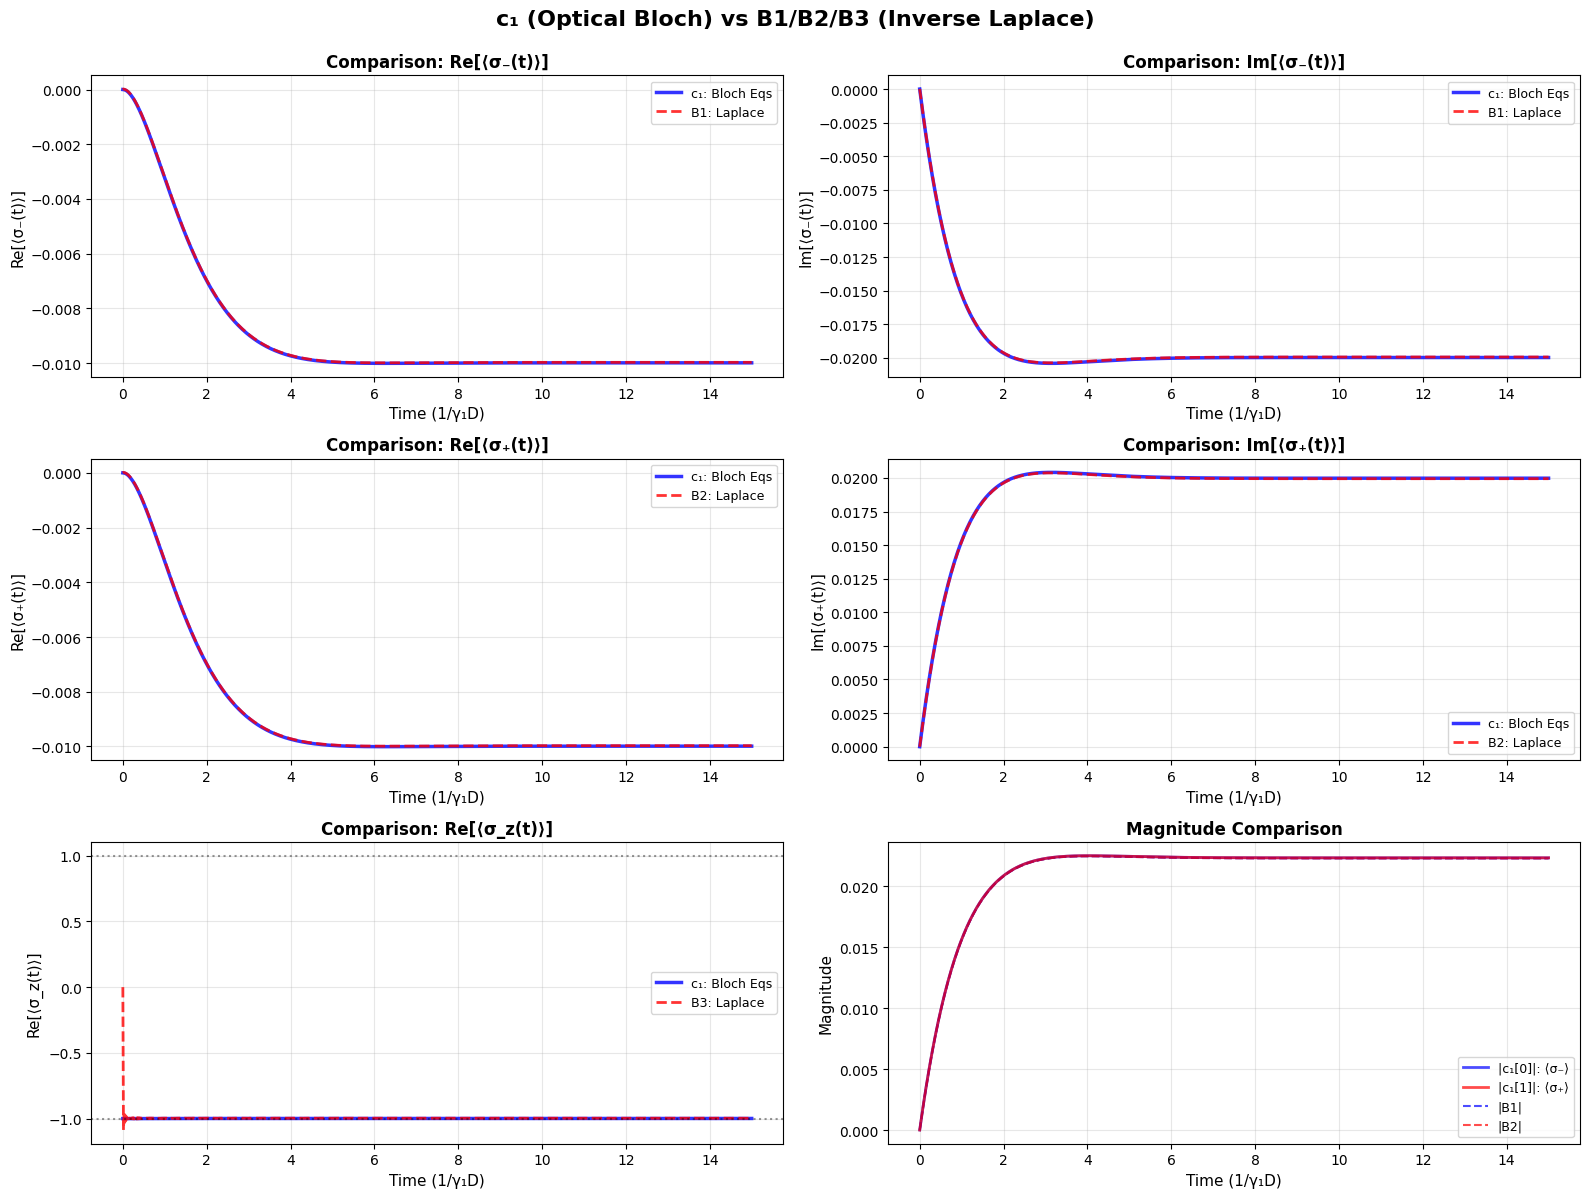

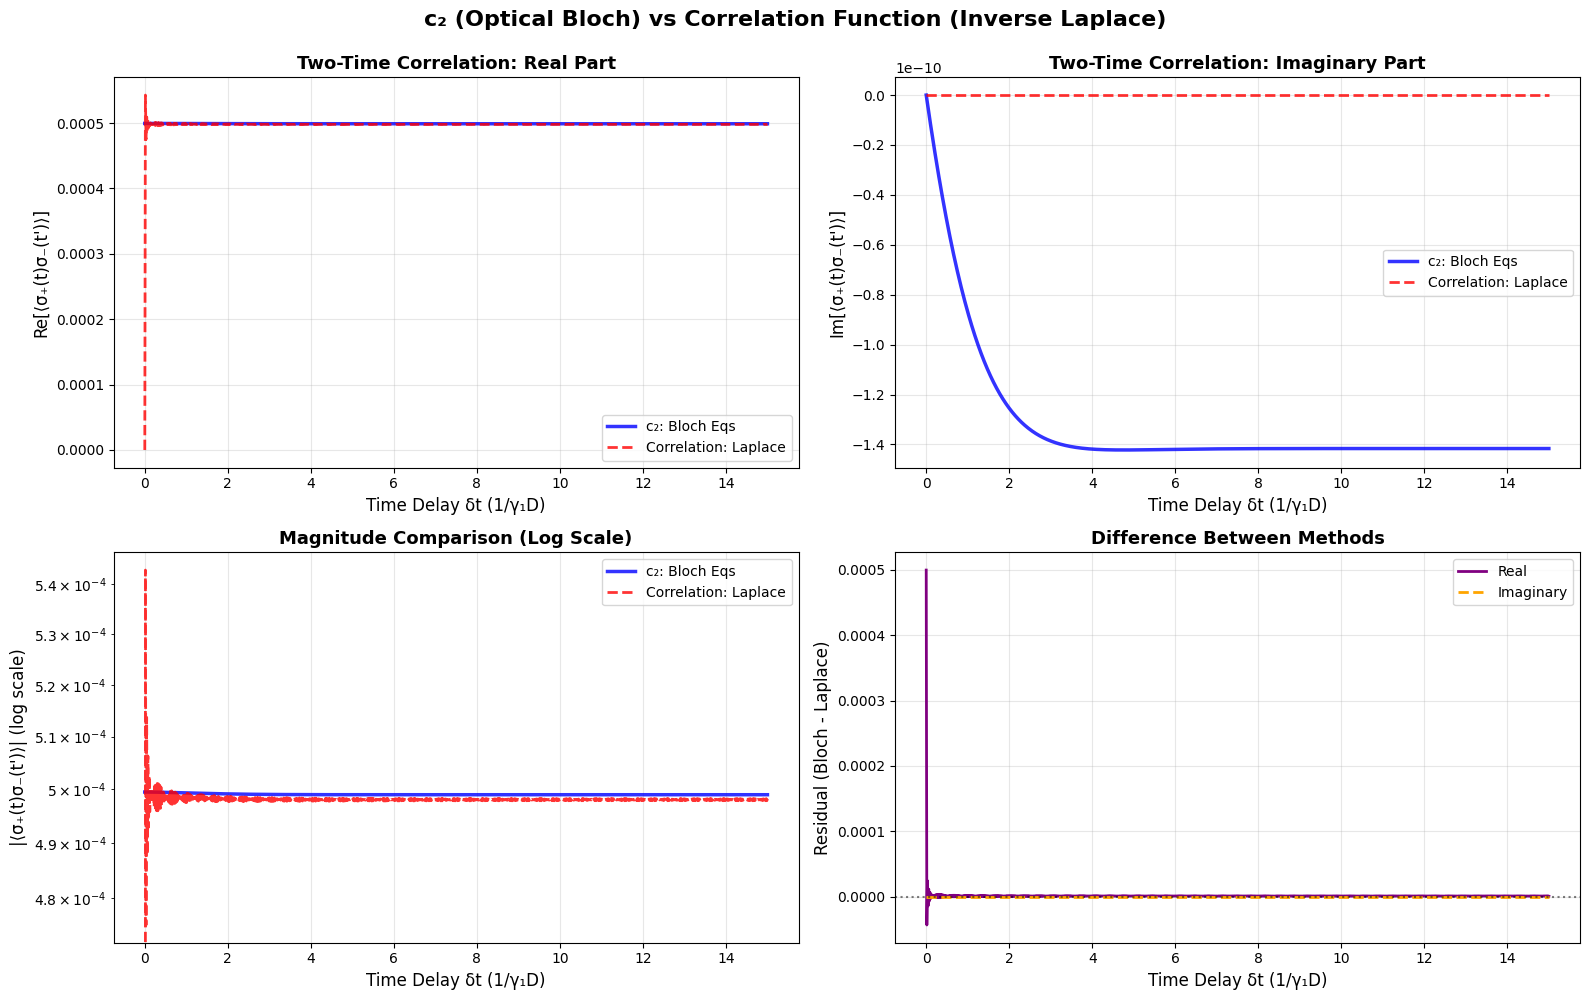


✓ Analysis complete!


In [ ]:
# @title
# ========== Method 1: Optical Bloch Equations ==========
print("=" * 70)
print("Optical Bloch Equations with Time-Dependent Phases")
print("=" * 70)
print(f"\nParameters: γ₁D={gamma_1D}, D={D}, ωR={Omega_R}, k={k}")

print("\n[1/3] Solving optical Bloch equations (c₁ and c₂)...")

# Solve c₁
c1_initial = get_initial_c1_from_state(psi_ground)
print(f"  Initial: ⟨σ₋⟩={c1_initial[0]}, ⟨σ₊⟩={c1_initial[1]}, ⟨σz⟩={c1_initial[2]}")

solution_c1 = solve_c1(c1_initial, times, k, gamma_1D, D, Omega_R)

c1_steady = solution_c1.y[:, -1]
print(f"  Steady state: ⟨σ₋⟩={c1_steady[0]:.6e}")
print(f"                ⟨σ₊⟩={c1_steady[1]:.6e}")
print(f"                ⟨σz⟩={c1_steady[2].real:.6f}")

# ==================== Modulating ================
sigma_minus_c1 = solution_c1.y[0]
sigma_plus_c1 = solution_c1.y[1]
sigma_z_c1 = solution_c1.y[2]

# Solve c₂
print("\n[2/2] Solving c₂ (two-time correlations)...")

sigma_plus_steady = c1_steady[1]
t_steady = times[-1]
c2_initial = get_initial_c2_from_c1_steady_state(c1_steady)

print(f"  Initial:")
print(f"    ⟨σ₊σ₋⟩(0) = {c2_initial[0]:.6e}  [(σz+1)/2]")
print(f"    ⟨σ₊σ₊⟩(0) = {c2_initial[1]:.6e}")
print(f"    ⟨σ₊σz⟩(0) = {c2_initial[2]:.6e}  [-σ₊]")

# In rotating frame (k=0), t_reference doesn't matter
# If k≠0, you'd set t_reference to the steady-state time
solution_c2 = solve_c2(c2_initial, delay_times, k, gamma_1D, D, Omega_R,
                        sigma_plus_steady, t_reference=t_steady)

print(f"\n  Final values:")
print(f"    ⟨σ₊σ₋⟩(δt=10) = {solution_c2.y[0,-1]:.6e}")

print(f"  c₂ initial ⟨σ₊σ₋⟩ = {solution_c2.y[0,0]:.6e}")

# ========== Method 2: Inverse Laplace Transform ==========
print("\n[2/3] Computing inverse Laplace transforms...")
omega_range = np.linspace(-50, 50, 2000)

B1_time = compute_B1(times, Omega_R, gamma_1D, D, k)
B2_time = compute_B2(times, Omega_R, gamma_1D, D, k)
B3_time = compute_B3(times, Omega_R, gamma_1D, D)
correlation_time = compute_correlation(delay_times, Omega_R, gamma_1D, D, k)


print(f"  B2 final = {B2_time[-1]:.6e}")
print(f"  Correlation initial = {correlation_time[0]:.6e}")

# ========== Plotting ==========
print("\n[3/3] Creating comparison plots...")

fig1 = plot_c1_vs_laplace(solution_c1, times, B1_time, B2_time, B3_time)

fig2 = plot_c2_vs_correlation(solution_c2, delay_times, correlation_time)

plt.show()

print("\n" + "="*70)
print("✓ Analysis complete!")
print("="*70)

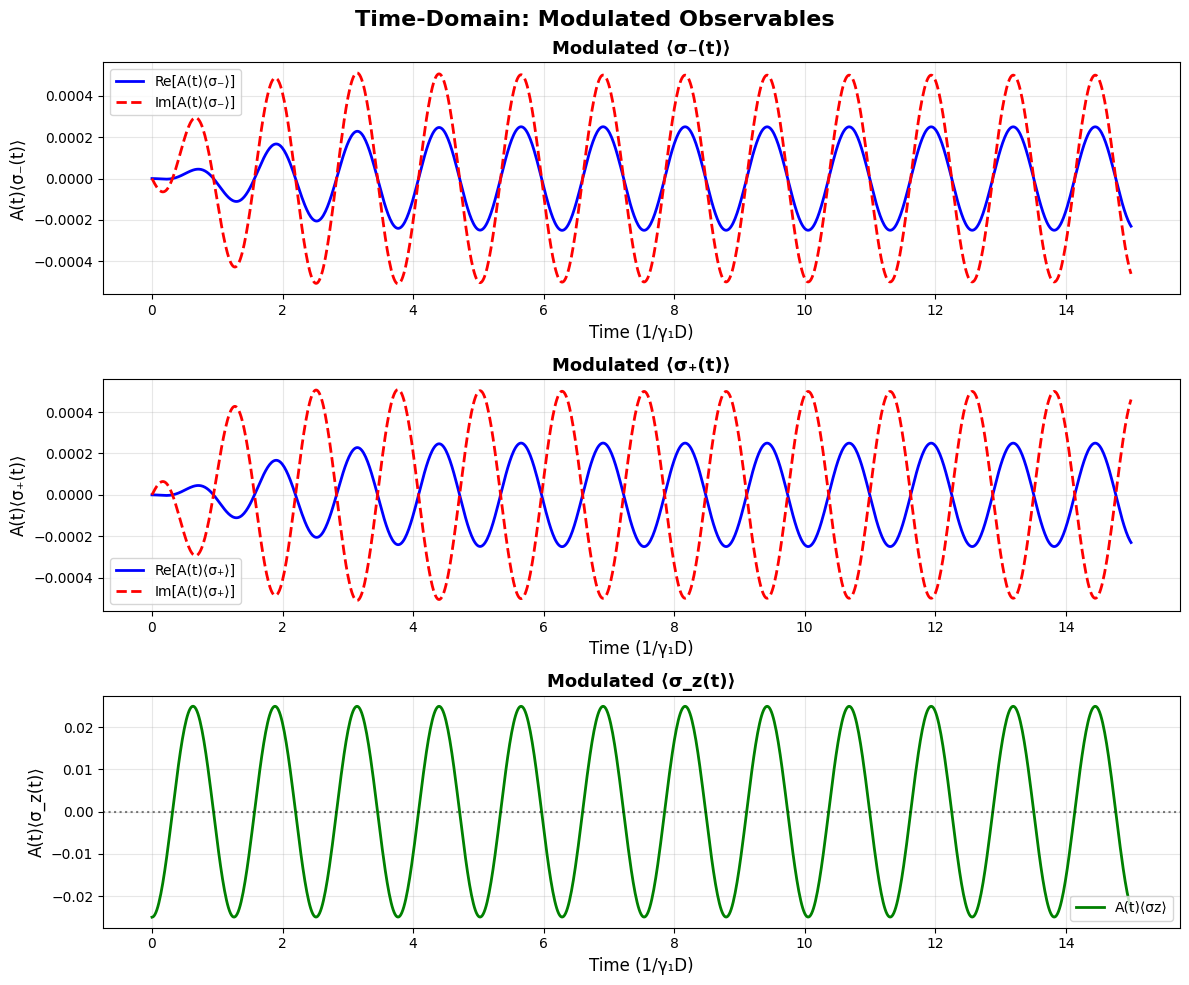

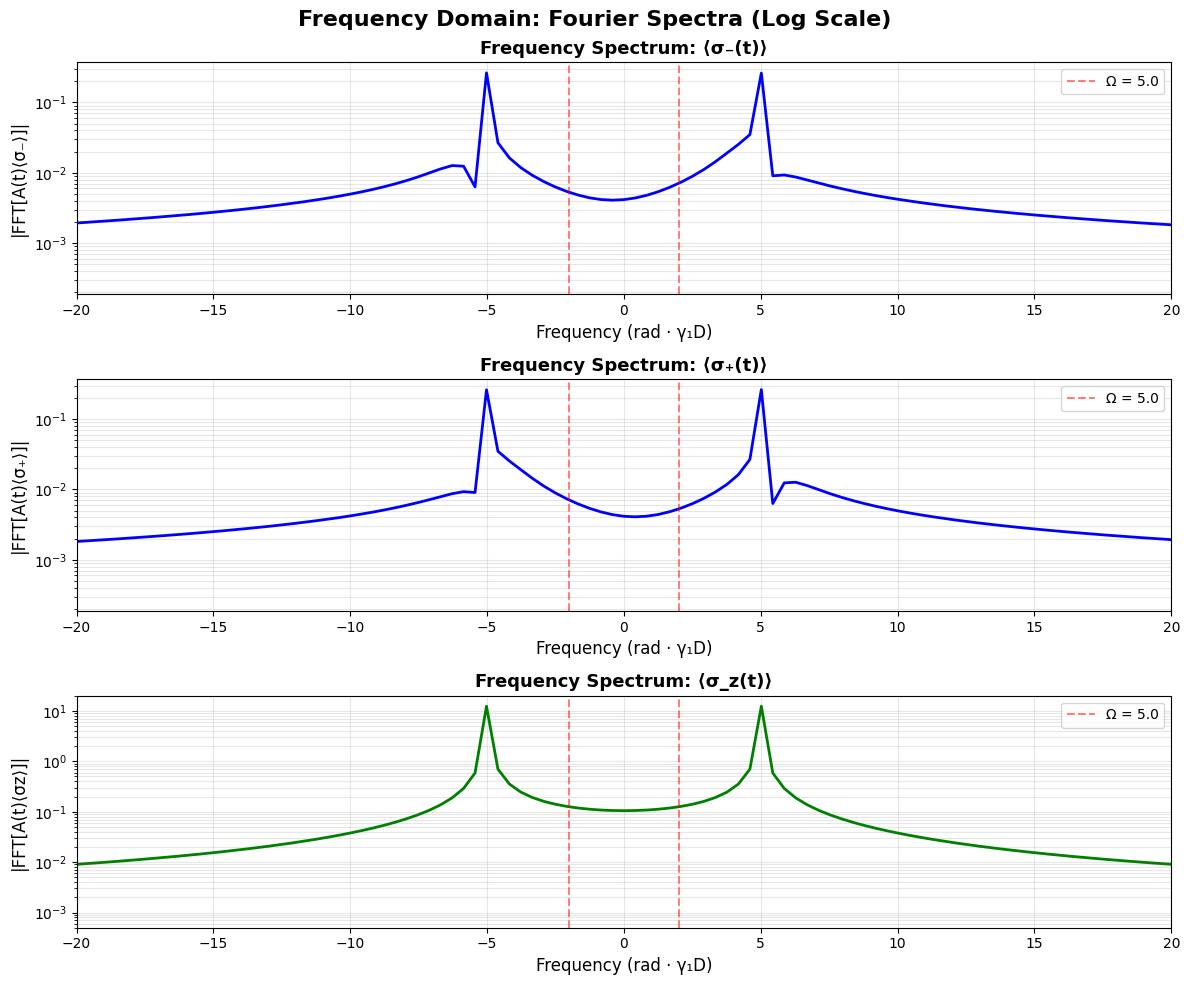

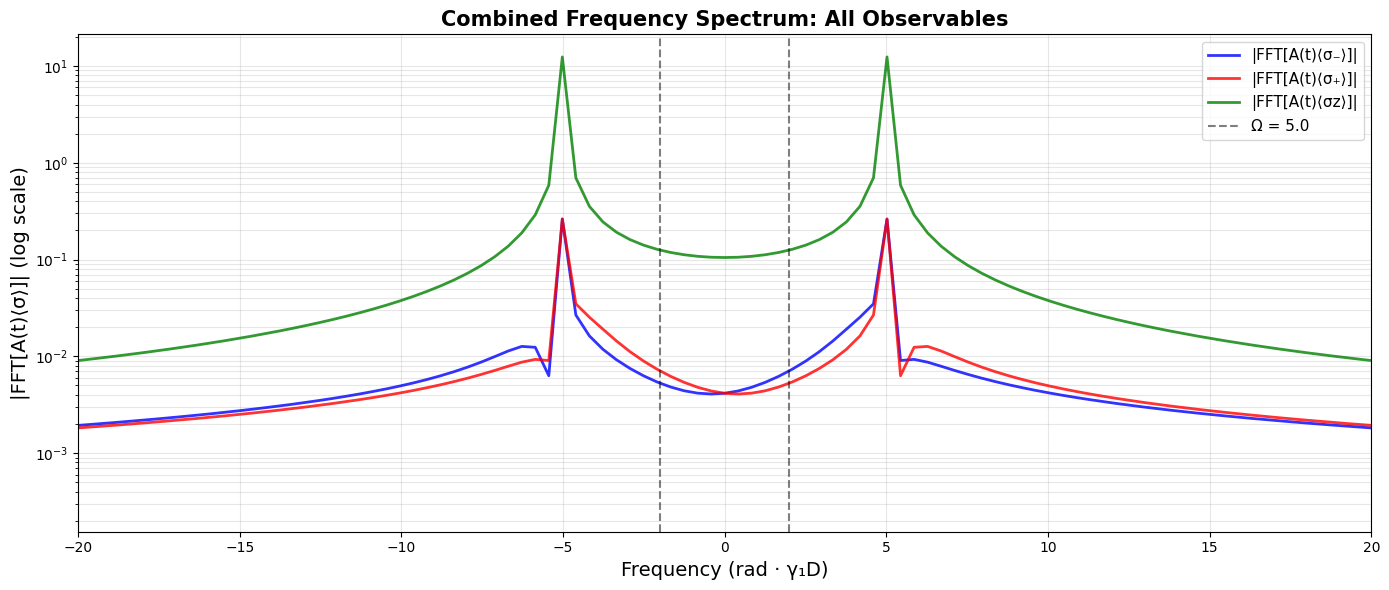

In [ ]:
# @title
A_mod = np.array([A_modulation(t) for t in times])

# Time domain plots
fig_mod_time = plot_modulated_observables(times, sigma_minus_c1, sigma_plus_c1, sigma_z_c1, A_mod)

# Frequency domain plots (separate)
fig_mod_freq = plot_fourier_spectrum(times, sigma_minus_c1, sigma_plus_c1, sigma_z_c1, A_mod)

# Combined frequency plot
fig_mod_combined = plot_combined_spectrum(times, sigma_minus_c1, sigma_plus_c1, sigma_z_c1, A_mod)

plt.show()